# Getting started with `evofr`

We begin by loading `pandas` to process our data from a `.tsv` file to a `pandas.DataFrame`.
We also load `evofr` which will be used to specify our data format for pre-processing, the model we'll used for estimation, and our inference method.

In what follows, we use the `ef.VariantFrequencies` dataspec which will handle formatting the data for input to our model.

In [1]:
import pandas as pd
import evofr as ef

In [2]:
# Getting data
raw_seq = pd.read_csv("../../test/testing_data/mlr-variant-counts.tsv", sep="\t")
raw_seq = raw_seq[raw_seq.location == "City0"]
variant_frequencies = ef.VariantFrequencies(raw_seq, pivot="C")

In `evofr`, we can specify a model by just calling a model constructor.
The simplest model in `evofr`for relative fitness estimation which takes in the generation time which we'll use to convert from relative fitness to growth advantage.

Underneath the hood, this model is estimating initial variant frequencies $f_v(0)$ and relative fitness $\lambda_v$, so that our variant frequencies over time $f_v(t)$ can be written as

$$
f_v(t) = \frac{f_v(0) e^{\lambda_v t}}{\sum_{u} f_u(0) e^{\lambda_u t}} = \frac{\exp(\alpha_v + \beta_v t)}{\sum_u \exp(\alpha_u + \beta_u t)},
$$
where we fix $\alpha_{u^*} = \beta_{u^*} = 0$ for some pivot variant `u^*`. 
This idea of a pivot variant is maintained with these frequency-based models can be specified withe `pivot` arugment in the [ef.VariantFrequencies](../source/evofr.data.rst#evofr.data.variant_frequencies.VariantFrequencies) constructor.

In [3]:
# Defining model
mlr = ef.MultinomialLogisticRegression(tau=4.2)

In this example, we'll use [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) (MCMC) sampling via the [NUTS](http://www.stat.columbia.edu/~gelman/research/published/nuts.pdf) sampler for 1000 warmup samples and 1000 samples.

In [4]:
# Defining inference method
inference_method = ef.InferNUTS(num_samples=1000, num_warmup=1000)

From here, getting our posterior and running our model is as simple as running the following line of code.

In [5]:
# Fitting model
posterior = inference_method.fit(mlr, variant_frequencies)

sample: 100%|█████████████████████████████████████████| 2000/2000 [00:00<00:00, 2316.21it/s, 15 steps of size 1.01e-01. acc. prob=0.95]


This `ef.PosteriorHandler` object will contain our data (attribute: `data`) and estimated parameters (attribute: `samples`).

In [6]:
# Forecasting using the model and posterior samples
forecast_L = 50
posterior.samples = mlr.forecast_frequencies(posterior.samples, forecast_L)

## Handling model results

We can save and load posteriors using commands on the posterior such as `posterior.save_posterior` and `posterior.load_posterior`.
The current supported outputs are `json` and `pickle`.

In [7]:
posterior.save_posterior("mlr_estimates.pkl")
# Loading new posterior
loaded_posterior = ef.PosteriorHandler(data=variant_frequencies).load_posterior("mlr_estimates.pkl")

## Exporting as DataFrames


In [8]:
# TODO:

## Plotting model results

There are several methods and classes implementing for taking a quick glance at your data.

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

font = {'family' : 'Helvetica',
        'weight' : 'light',
        'size'   : 24}

matplotlib.rc('font', **font)

In [10]:
ps = [0.95, 0.8, 0.5]
alphas = [0.2, 0.4, 0.6]


v_colors = ["#56e39f", "#89CFF0", "#C70039"]
v_names = ['A', 'B', 'C']
color_map = {v : c for c, v in zip(v_colors, v_names)}

In [11]:
from evofr.plotting import FrequencyPlot, GrowthAdvantagePlot, PatchLegend, add_dates_sep
from evofr.plotting import plot_site_in_time, plot_variants, plot_time_series_with_variants

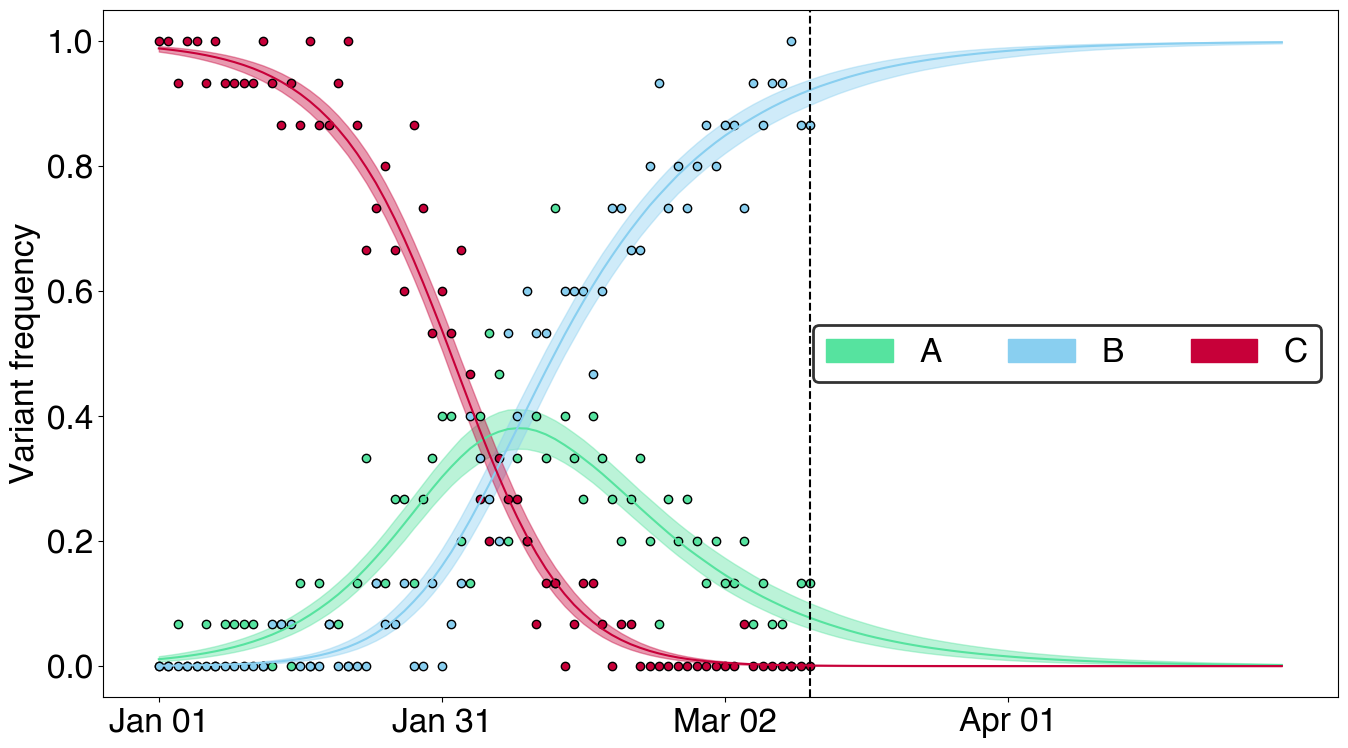

In [12]:
# Plot predicted frequencies
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0,0])

FrequencyPlot(posterior, color_map=color_map).plot(ax, forecast=True)
ax.axvline(x=len(variant_frequencies.dates)-1, color='k', linestyle='--') # Adding forecast cut off
add_dates_sep(ax, ef.data.expand_dates(variant_frequencies.dates, forecast_L), sep=30) # Adding dates
PatchLegend(color_map).add_legend(ax)

fig.tight_layout()

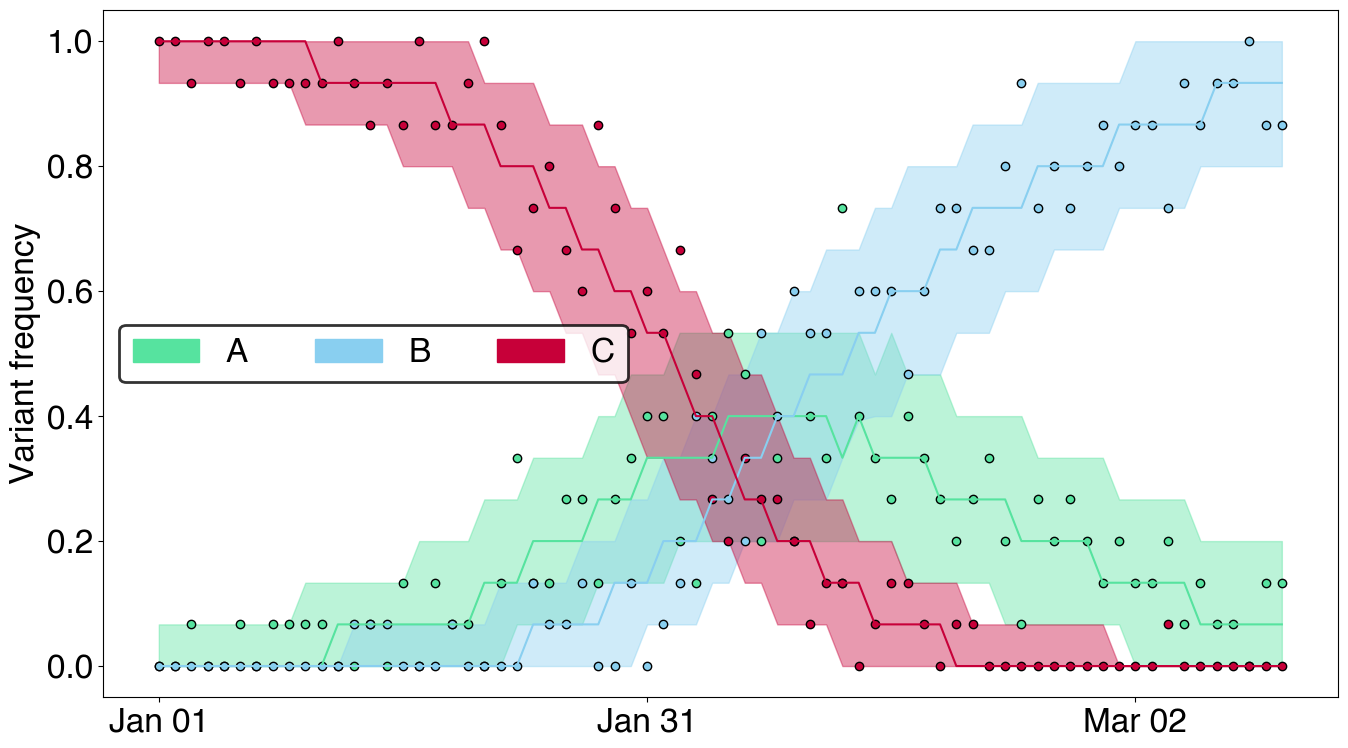

In [13]:
# Plot posterior predictive frequency
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0,0])

FrequencyPlot(posterior, color_map=color_map).plot(ax, posterior=False, predictive=True)
add_dates_sep(ax, variant_frequencies.dates, sep=30) # Adding dates
PatchLegend(color_map).add_legend(ax)
fig.tight_layout()

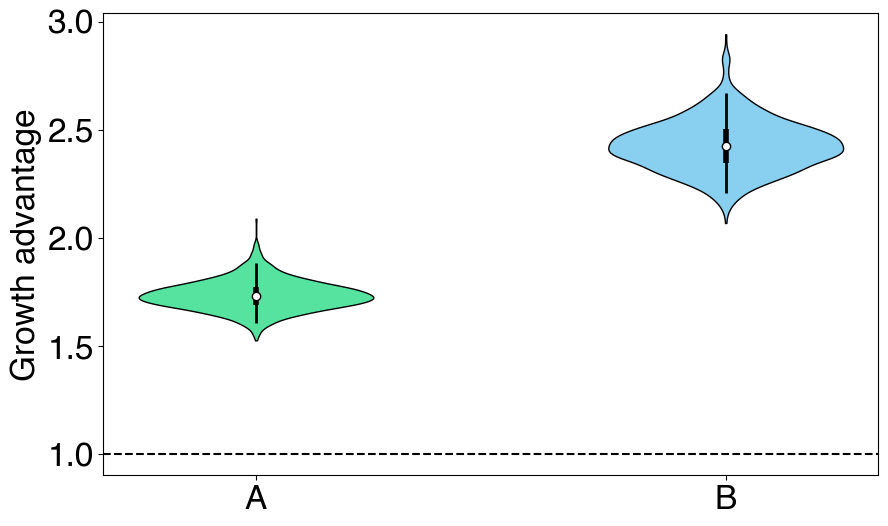

In [14]:
# Plotting growth advantage
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0,0])

GrowthAdvantagePlot(posterior, color_map=color_map).plot(ax=ax)

Text(0, 0.5, 'Mean fitness')

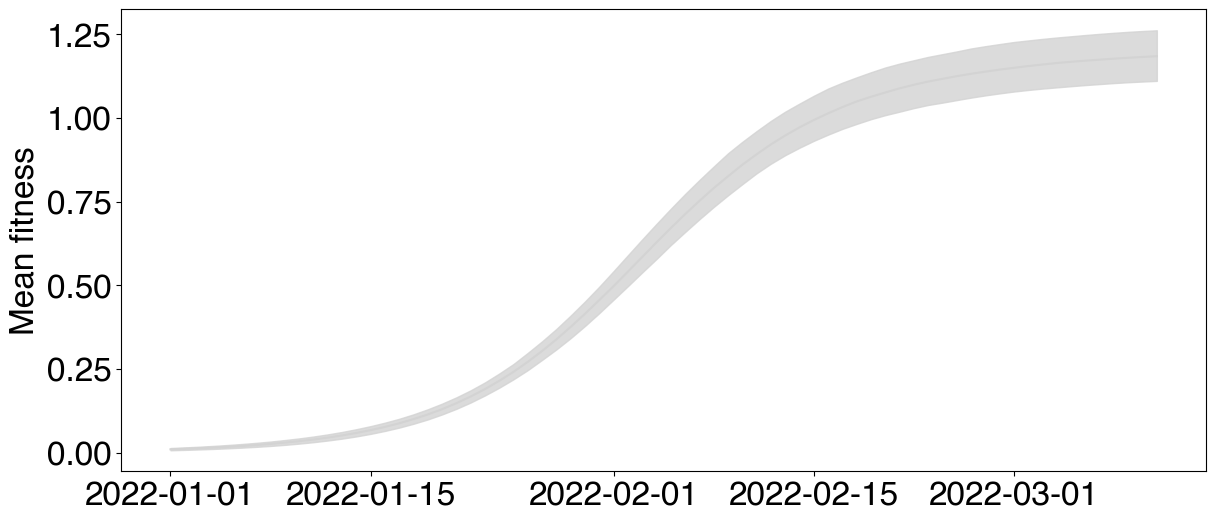

In [15]:
# Computing and plotting mean fitness using `plot_site_in_time` primitive
fig, ax = plt.subplots(figsize=(14,6))
posterior.samples["delta_bar"] = (posterior.samples["freq"][:, :, :-1] * posterior.samples["ga"][:, None, :]).mean(axis=-1)
plot_site_in_time(ax, posterior.samples, "delta_bar", dates = posterior.data.dates, alphas=[0.8], colors="lightgray", quantiles=[0.8])
ax.set_ylabel("Mean fitness")

Text(0, 0.5, 'Growth Advantage')

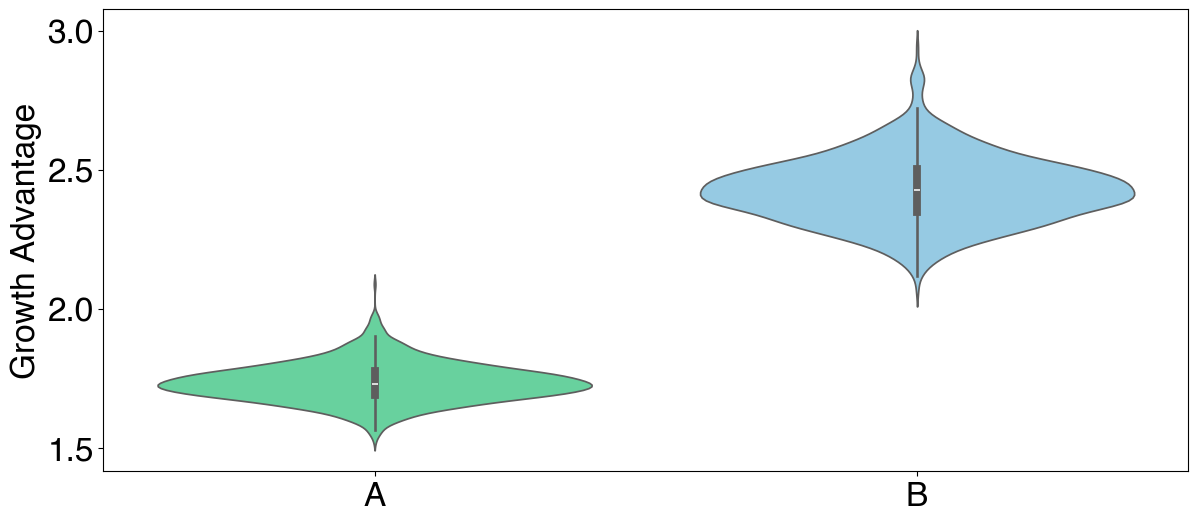

In [16]:
# Plotting growth advantage using `plot_variants` primitive
fig, ax = plt.subplots(figsize=(14,6))
plot_variants(ax, 
              posterior.samples, 
              "ga", 
              color_map=color_map, 
              variants=posterior.data.var_names, 
              variants_to_plot = ["A", "B"])
ax.set_ylabel("Growth Advantage")

Text(0, 0.5, 'Variant Frequency')

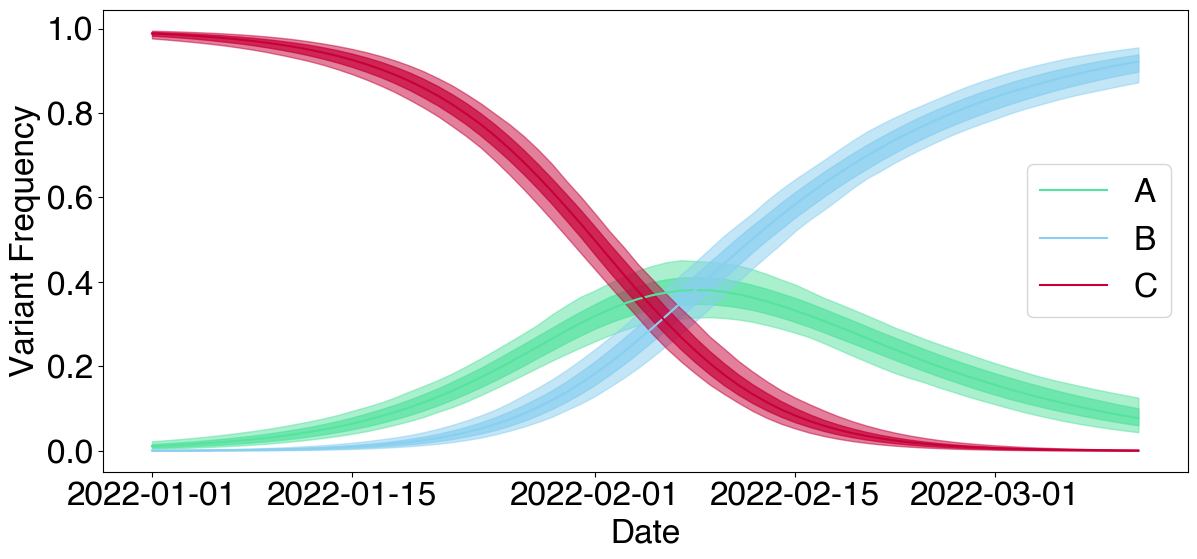

In [17]:
# Plotting variant frequency using `plot_time_series_with_variants` primitive
fig, ax = plt.subplots(figsize=(14,6))
plot_time_series_with_variants(ax, 
                               posterior.samples, "freq", 
                               variants=posterior.data.var_names, 
                               dates = posterior.data.dates,               
                               color_map=color_map, 
                               alphas = [0.5, 0.7],
                               quantiles=[0.99, 0.8]
)
ax.set_ylabel("Variant Frequency")